In [10]:
import numpy as np
import pandas as pd
import cloudpickle
from matplotlib.offsetbox import AnchoredText
import matplotlib.pyplot as plt
import random
from pathlib import Path
import seaborn as sns

from scipy.stats import linregress
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.base import TransformerMixin

random_state = 42
np.random.seed(42)
random.seed(42)
sns.set_theme(font='Arial')
plt.rcParams['text.latex.preamble'] = r'\usepackage{bm}'

class RemCorr(TransformerMixin):
    def __init__(self, threshold=None, cols_to_keep=None):
        self.threshold = threshold
        self.cols_to_keep = cols_to_keep

    def __repr__(self):
        return f"RemCorr(threshold={self.threshold})"

    def fit(self, X, y=None):
        """
        Response by User: @Synergix to Stack Question:
        https://stackoverflow.com/a/61938339/19293517

        Objective:
            Remove collinear features in a dataframe with a correlation coefficient
            greater than the threshold. Removing collinear features can help a model
            to generalize and improves the interpretability of the model.

        Inputs:
            x: features dataframe
            threshold: features with correlations greater than this value are removed

        Output:
            dataframe that contains only the non-highly-collinear features
        """

        # Calculate the correlation matrix
        x = pd.DataFrame(data=X)
        corr_matrix = x.corr()
        iters = range(len(corr_matrix.columns) - 1)
        drop_cols = []

        # Iterate through the correlation matrix and compare correlations
        for i in iters:
            for j in range(i + 1):
                item = corr_matrix.iloc[j : (j + 1), (i + 1) : (i + 2)]
                col = item.columns
                row = item.index
                val = abs(item.values)

                # If correlation exceeds the threshold
                if val >= self.threshold:
                    # Print the correlated features and the correlation value
                    # print(col.values[0], "|", row.values[0], "|", round(val[0][0], 2))
                    drop_cols.append(col.values[0])

        # Drop one of each pair of correlated columns
        drops = set(drop_cols)
        x = x.drop(columns=drops)
        self.cols_to_keep = x.columns
        return self

    def transform(self, X: np.ndarray, y=None):
        return X[:, self.cols_to_keep]

    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X)

    def get_params(self, deep=True):
        return {
            key: value
            for key, value in self.__dict__.items()
            if not key.startswith("_")
        }

    def set_params(self, **params):
        for key, value in params.items():
            setattr(self, key, value)
        return self

    def get_feature_names_out(self):
        return self.cols_to_keep

def plot_indvl_regression(
    ax,
    estimator: Pipeline,
    _X_train: pd.DataFrame,
    _X_test: pd.DataFrame,
    _Y_train: pd.DataFrame,
    _Y_test: pd.DataFrame,
    plot_title="Default Model",
):
    # Predicts and reshapes to make it usable
    pred_Xtrain = estimator.predict(_X_train)

    TSS_tr = sum((_Y_train - _Y_train.mean())**2)
    TSS_ex = sum((_Y_test - _Y_test.mean())**2)


    # Metrics for Train Data in Model
    train_R2 = r2_score(y_true=_Y_train, y_pred=pred_Xtrain)
    train_mae = mean_absolute_error(y_true=_Y_train, y_pred=pred_Xtrain)
    train_slope, train_intercept, train_rvalue, train_pvalue, train_stderr = (
        linregress(_Y_train, pred_Xtrain)
    )
    train_spearmanr2 = train_rvalue**2

    avg_fill = np.full(shape=_Y_train.shape, fill_value=_Y_train.mean())
    pred_avg = mean_absolute_error(y_true=_Y_train, y_pred=avg_fill)
    print(f'This is the MAE if predicting just the average: {pred_avg}')

    pred_Xtest = estimator.predict(_X_test)        

    # Metrics for Test Data in Model
    test_R2 = r2_score(y_true=_Y_test, y_pred=pred_Xtest)
    test_mae = mean_absolute_error(y_true=_Y_test, y_pred=pred_Xtest)
    test_slope, test_intercept, test_rvalue, test_pvalue, test_stderr = linregress(
        _Y_test, pred_Xtest
    )
    test_spearmanr2 = test_rvalue**2
    
    Ex_PRESS = sum((_Y_test - pred_Xtest)**2)

    #See DOI: 10.1021/acs.jcim.6b00277
    Q2_F3 = 1- (Ex_PRESS/len(pred_Xtest)) / (TSS_tr/len(_Y_test))

    ax.scatter(
        x=_Y_train,
        y=pred_Xtrain,
        edgecolors="tab:orange",
        c="tab:orange",
        alpha=0.5,
        label="Train",
    )
    ax.axline(
        (0, train_intercept),
        slope=train_slope,
        color="tab:orange",
        ls="dotted",
        label="_nolegend_",
    )
    ax.scatter(
        x=_Y_test,
        y=pred_Xtest,
        edgecolors="tab:blue",
        c="tab:blue",
        alpha=0.5,
        label="Test",
    )
    ax.axline(
        (0, test_intercept),
        slope=test_slope,
        color="tab:blue",
        ls="dotted",
        label="_nolegend_",
    )

    ax.legend(loc="upper right")
    R2 = r'$\mathbf{R^2}$'
    r2 = r'$\mathbf{r^2}$'
    F3=r"$\mathbf{Q^2_{F3}}$"
    at = AnchoredText(
        f"""Train:
{R2}={train_R2:.3f}
MAE={train_mae:.3f}
Test:
{r2}={test_spearmanr2:.3f}
{F3}={Q2_F3:.3f}
MAE={test_mae:.3f}""",
        prop=dict(size=12, weight='bold'),
        frameon=True,
        loc="upper left",
    )

    at.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    at.patch.set_alpha(0.15)
    ax.add_artist(at)
    ax.set_title(plot_title, fontsize=20)
    ax.set_xlabel(r"Observed $\Delta\Delta$$G^\ddag$ (kcal/mol)",fontsize=18)

    ax.set_ylabel(r"Predicted $\Delta\Delta$$G^\ddag$ (kcal/mol)",fontsize=18)

    ax.set_xlim((0, 3.5))
    ax.set_ylim((0, 3.5))
    ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
    ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)
    plt.tight_layout()
    
    return {
        "Train R^2": train_R2,
        "Train r^2": train_spearmanr2,
        "Train MAE": train_mae,
        "Test R^2": test_R2,
        "Test r^2": test_spearmanr2,
        "Test MAE": test_mae,
    }

In [ ]:
alk_types = [
"Mono",
"Gem",
"Cis",
"Trans",
"TriQ2",
"TriQ3",
"TriQ4",
"Tetra",
]

This is the MAE if predicting just the average: 0.6414410295592902


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.7233371077529699


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.43103087032578297


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.46845230222251294


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.666462266349218


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.49294325565353275


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.5632420346868349


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


This is the MAE if predicting just the average: 0.35370749920783406


C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:195: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), fontsize=16)
C:\Users\BlakeOcampo\AppData\Local\Temp\ipykernel_20400\3547627225.py:196: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_yticklabels(ax.get_yticklabels(), fontsize=16)


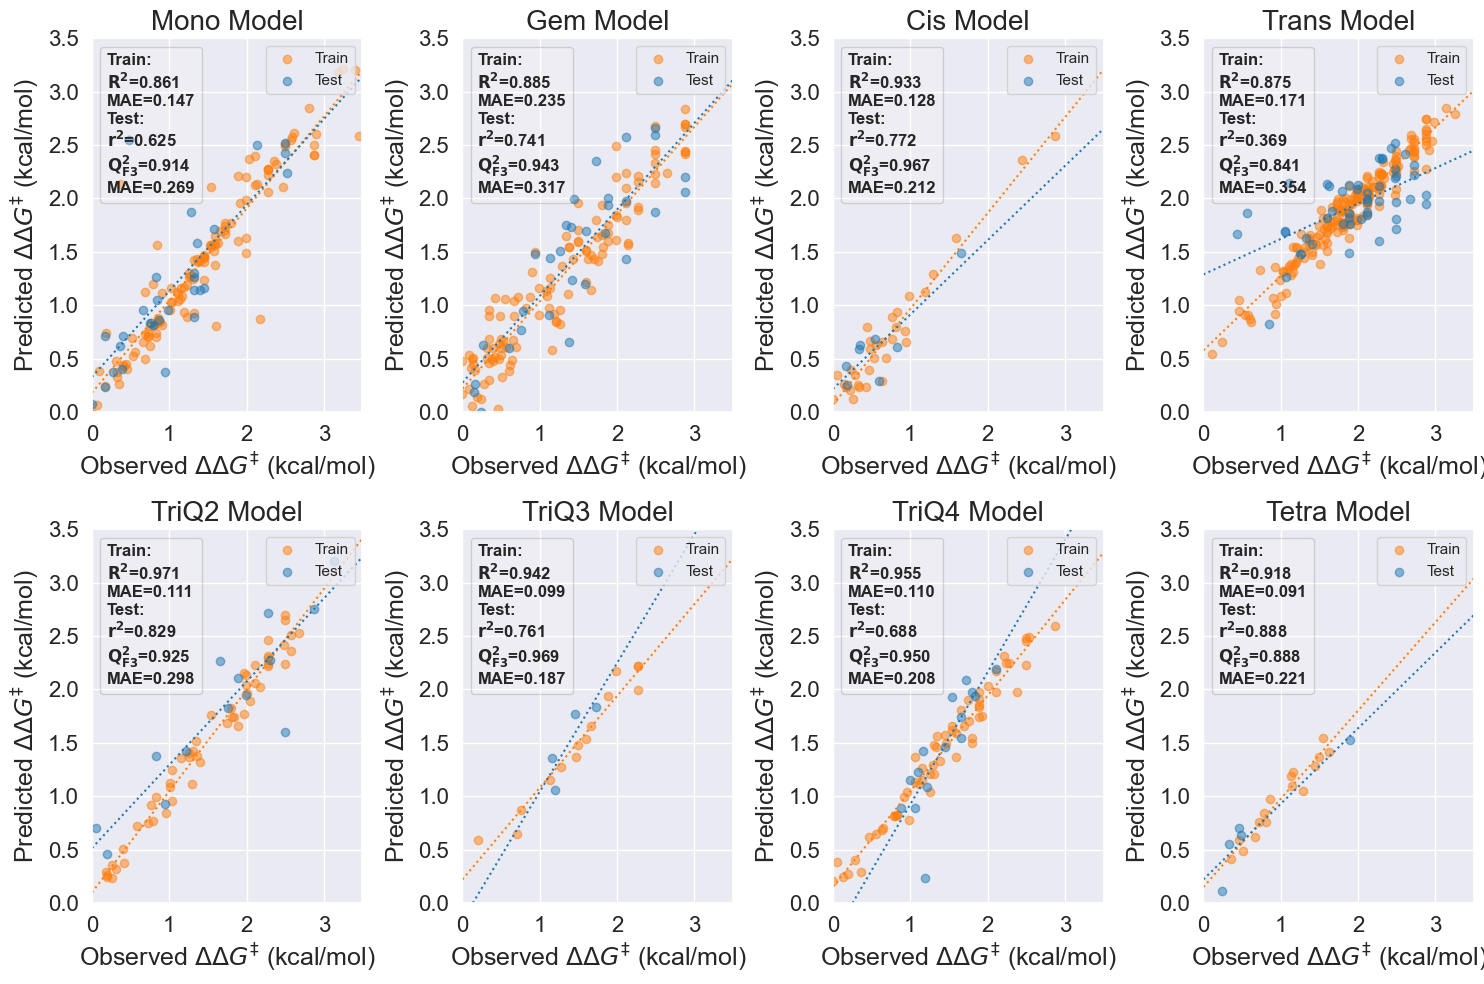

In [ ]:
fig, axes = plt.subplots(2,4, figsize=(15,10))

for (alk_type,ax) in zip(alk_types, axes.flat):

    model_path = Path(f'./Trained_Models/')
    dir_path = Path(f'./Train_Test_Splits')

    X_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Train')
    Y_train = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Train')
    X_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='X_Test')
    Y_test = pd.read_hdf(f"{dir_path}/{alk_type}_Train_Test_Split.hdf5", key='Y_Test')

    with open(f"{model_path}/{alk_type}_Final_Train_Only_Model.cpkl", 'rb') as f:
        train_pipe = cloudpickle.load(f)

    model_res = plot_indvl_regression(
        ax,
        train_pipe,
        _X_train=X_train,
        _X_test=X_test,
        _Y_train=Y_train,
        _Y_test=Y_test,
        plot_title=f"{alk_type} Model",
    )
